# Trait Cosine Similarity with Contrast Vector

In [1]:
import os
import sys
import torch
import numpy as np
import torch.nn.functional as F

sys.path.append('.')
sys.path.append('..')

import matplotlib.pyplot as plt
plt.style.use('./arena.mplstyle')

In [2]:
# Config
plot_output_dir = "/root/git/plots/paper"
model_short = "llama-3.3-70b"
layer = 40
dir = f"/workspace/{model_short}"

In [47]:
# Load trait PCA results
trait_results = torch.load(f"{dir}/traits_240/pca/layer{layer}_pos-neg50.pt", weights_only=False)
trait_names = trait_results['traits']['pos_neg_50']

# Load contrast vector
contrast_vector = torch.load(f"{dir}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
contrast_vector = F.normalize(contrast_vector, dim=0).float() * -1

/root/git/persona-subspace/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/git/persona-subspace/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [48]:
# Get trait vectors at layer and normalize
trait_tensor = torch.stack(trait_results['vectors']['pos_neg_50'])
trait_layer_vectors = trait_tensor[:, layer].float()

normalized_trait_vectors = F.normalize(trait_layer_vectors, dim=1)


# Compute cosine similarities
trait_cosine_sims = (normalized_trait_vectors @ contrast_vector).numpy()
print(f"Trait cosine sims shape: {trait_cosine_sims.shape}")
print(f"Range: [{trait_cosine_sims.min():.3f}, {trait_cosine_sims.max():.3f}]")

Trait cosine sims shape: (240,)
Range: [-0.706, 0.649]


In [49]:
# Print top 20 traits at each end
sorted_indices = np.argsort(trait_cosine_sims)

print("=== Top 20 NEGATIVE (Assistant-like) ===")
for i, idx in enumerate(sorted_indices[:20]):
    print(f"{i+1:2d}. {trait_names[idx]:20s} {trait_cosine_sims[idx]:.3f}")

print("\n=== Top 20 POSITIVE (Role-playing) ===")
for i, idx in enumerate(sorted_indices[-20:][::-1]):
    print(f"{i+1:2d}. {trait_names[idx]:20s} {trait_cosine_sims[idx]:.3f}")

=== Top 20 NEGATIVE (Assistant-like) ===
 1. enigmatic            -0.706
 2. whimsical            -0.692
 3. cryptic              -0.676
 4. grandiose            -0.664
 5. romantic             -0.664
 6. spontaneous          -0.661
 7. ethereal             -0.650
 8. rhetorical           -0.636
 9. mystical             -0.635
10. dramatic             -0.608
11. obsessive            -0.607
12. narrative            -0.605
13. melodramatic         -0.599
14. mercurial            -0.594
15. metaphorical         -0.587
16. subversive           -0.586
17. nostalgic            -0.586
18. flirty               -0.568
19. spiritual            -0.560
20. mischievous          -0.560

=== Top 20 POSITIVE (Role-playing) ===
 1. transparent          0.649
 2. grounded             0.522
 3. factual              0.503
 4. flexible             0.460
 5. moderate             0.460
 6. diplomatic           0.424
 7. reserved             0.424
 8. accessible           0.398
 9. conciliatory         0.387


In [92]:
from matplotlib.colors import LinearSegmentedColormap

def plot_trait_line(cosine_sims, trait_names, include_labels=None, exclude_labels=None,
                    title=None, figsize=(8, 3), n_extremes=6, show_histogram=True):
    """
    Plot trait cosine similarities on a line (adapted from plot_pc_line).

    Args:
        cosine_sims: (n_traits,) array of cosine similarities
        trait_names: List of trait names
        include_labels: List of trait names to always label
        exclude_labels: List of trait names to exclude from labeling
        title: Optional title string
        figsize: Figure size tuple
        n_extremes: Number of extremes to label on each end
        show_histogram: Whether to show histogram overlay
    """
    include_labels = include_labels or []
    exclude_labels = exclude_labels or []
    
    projections = cosine_sims
    
    # Build index sets for include/exclude
    trait_to_idx = {name: i for i, name in enumerate(trait_names)}
    include_idx = set(trait_to_idx[t] for t in include_labels if t in trait_to_idx)
    exclude_idx = set(trait_to_idx[t] for t in exclude_labels if t in trait_to_idx)
    
    # Find extreme indices
    sorted_indices = np.argsort(projections)
    low_extreme_indices = list(sorted_indices[:n_extremes*3:3])  # every 3rd from low end
    high_extreme_indices = list(sorted_indices[::-1][:n_extremes*3:3])  # every 3rd from high end
    extreme_indices = set(low_extreme_indices + high_extreme_indices)
    
    # Indices to label = extremes + include, minus exclude
    indices_to_label = (extreme_indices | include_idx) - exclude_idx
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Create gradient colormap: red (#e63946) to blue (#457b9d)
    custom_cmap = LinearSegmentedColormap.from_list('RedBlue1', ['#e63946', '#457b9d'])
    
    # Normalize projections for coloring (map to 0-1 range)
    proj_norm = (projections - projections.min()) / (projections.max() - projections.min())
    colors = custom_cmap(proj_norm)
    
    # Plot all points with gradient colors
    y_pos = np.zeros_like(projections)
    ax.scatter(projections, y_pos, c=colors, marker='D', s=40, 
               alpha=0.6, edgecolors='none', zorder=3)
    
    # Add histogram overlay
    if show_histogram:
        hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        hist_scale = 0.4
        scaled_heights = hist_counts * hist_scale
        
        # Color histogram bars with gradient
        bin_norm = (bin_centers - projections.min()) / (projections.max() - projections.min())
        bin_colors = custom_cmap(bin_norm)
        
        ax.bar(bin_centers, scaled_heights, width=bin_width, 
               alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
    
    # Fixed label heights - alternate above/below
    label_height_above = 0.2
    label_height_below = -0.2
    
    # Sort indices to label by projection value for consistent positioning
    sorted_label_indices = sorted(indices_to_label, key=lambda i: projections[i])
    
    for i, idx in enumerate(sorted_label_indices):
        label = trait_names[idx].replace('_', ' ').title()
        x_pos = projections[idx]
        y_label = label_height_above if i % 2 == 0 else label_height_below
        
        # Draw leader line
        ax.plot([x_pos, x_pos], [0.0, y_label], '--', color='black', alpha=0.7, linewidth=1, zorder=1)
        
        # Add text label at 45 degrees
        if y_label > 0:
            ax.text(x_pos, y_label, label, ha='left', va='bottom', fontsize=10, zorder=4,
                    rotation=45, rotation_mode='anchor')
        else:
            ax.text(x_pos, y_label, label, ha='right', va='top', fontsize=10, zorder=4,
                    rotation=45, rotation_mode='anchor')
    
    # Add directional annotations
    max_abs = max(abs(projections.min()), abs(projections.max()))
    
    # Left side: Role-playing traits (red arrow pointing left)
    left_x = -max_abs 
    ax.annotate('Role-playing', xy=(left_x, -0.55), xytext=(left_x + max_abs * 0.25, -0.55),
                arrowprops=dict(arrowstyle='->', color='#e63946', lw=2),
                fontsize=12, fontweight='bold', color='#e63946', ha='left', va='center')
    
    # Right side: Assistant-like traits (blue arrow pointing right)
    right_x = max_abs 
    ax.annotate('Assistant-like', xy=(right_x, -0.55), xytext=(right_x - max_abs * 0.25, -0.55),
                arrowprops=dict(arrowstyle='->', color='#457b9d', lw=2),
                fontsize=12, fontweight='bold', color='#457b9d', ha='right', va='center')
    
    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
    
    ax.tick_params(axis='x', length=12, width=1.5, pad=10)
    ax.tick_params(axis='y', length=0, width=0)
    ax.set_yticks([])
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_ylim(-0.6, 0.6)
    
    ax.set_xlim(-1, 1)
    
    ax.grid(False)

    plt.tight_layout()
    return fig

In [93]:
# Label configuration - adjust these lists as needed
trait_config = {
    'include_labels': ['grounded','flexible', 'factual','romantic', 'benevolent','subversive', 'mercurial', 'mischievous', 'cryptic', 'dramatic'],  # traits to always label
    'exclude_labels': ['melodramatic', 'reserved', 'secular', 'ethereal', 'mercurial', 'grandiose'],  # traits to never label
}

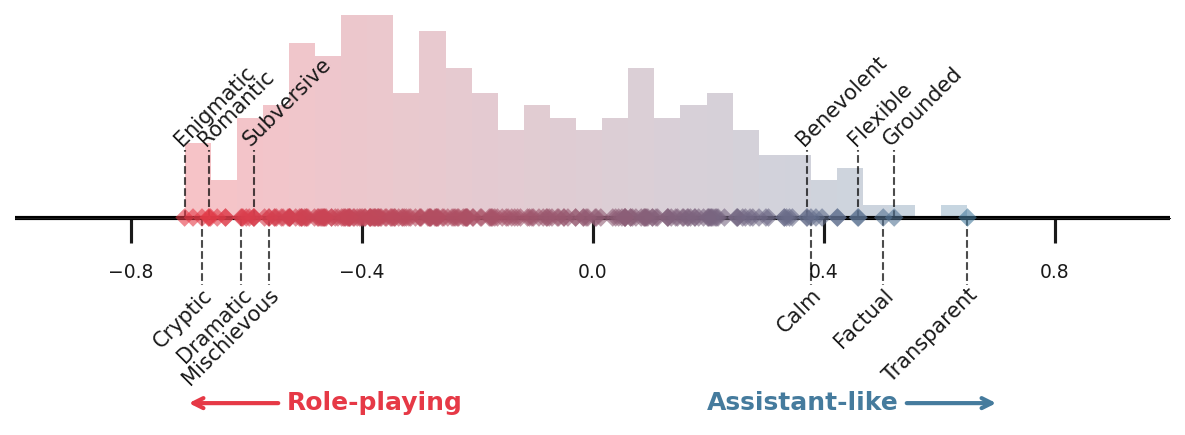

In [94]:
# Generate plot
fig = plot_trait_line(
    trait_cosine_sims, trait_names,
    include_labels=trait_config['include_labels'],
    exclude_labels=trait_config['exclude_labels'],
    n_extremes=5,
    show_histogram=True,
)
plt.savefig(f"{plot_output_dir}/trait_contrast_line.pdf", dpi=300, bbox_inches='tight')
plt.show()